<a href="https://colab.research.google.com/github/GabrielRocha97/GabrielRocha97.github.io/blob/main/case_enjoei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade google-cloud-bigquery
from google.colab import auth
auth.authenticate_user()

In [21]:
from google.cloud import bigquery

project_id = "bi-candidatos"
client = bigquery.Client(project=project_id)

In [22]:
query = """
SELECT *
FROM `bi-candidatos.recruitment_analytics.orders`
LIMIT 10
"""

df = client.query(query).to_dataframe()

PermissionDenied: 403 request failed: the user does not have 'bigquery.readsessions.create' permission for 'projects/bi-candidatos'

In [ ]:
## Não tenho acesso ao ambiente de conexão colab > gcp, então vou printar as consultas por aqui e ir comentando rsrs

In [ ]:
## primeira consulta
select EXTRACT(MONTH FROM date) mes
,sum(visits) visits
,sum(product_views) product_views
,sum(carts_created) carts_created
,sum(orders) orders
,sum(cast(orders_value as int)) orders_value
FROM `bi-candidatos.recruitment_analytics.funnel`
group by all
order by mes asc

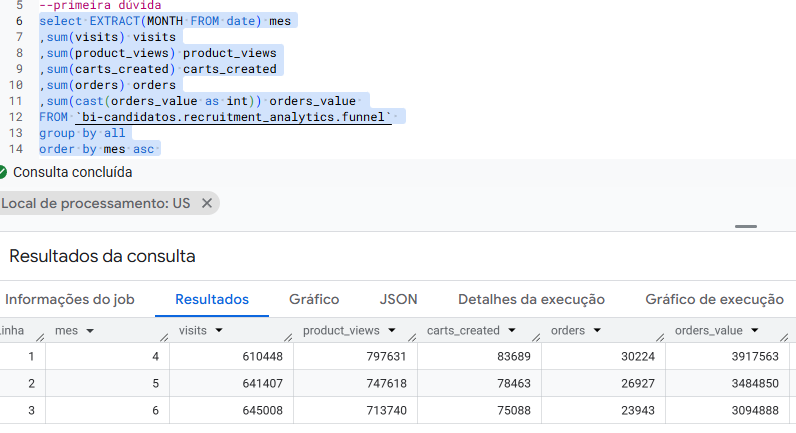

 Existe um aumento no volume de visitas do mes 4 para o mes 5, mas, queda brusca de visualização e carrinhos.
 Pedidos também tem uma queda brusca e a receita dos produtos também diminuiu

In [ ]:
## Feito isso, preciso entender o que aconteceu entre os meses, variação de visualizações, pedidos, etc

In [ ]:
## Resposta: aqui quantifico o quanto reduziu de cada item
          with base as (
  select
    EXTRACT(MONTH FROM date) mes
    ,sum(visits) visits
    ,sum(product_views) product_views
    ,sum(carts_created) carts_created
    ,sum(orders) orders
    ,sum(CAST(orders_value AS INT64)) orders_value
  FROM `bi-candidatos.recruitment_analytics.funnel`
  GROUP BY mes
              ) ,
comparativo AS (
  SELECT
    mes
    ,visits
    ,product_views
    ,carts_created
    ,orders
    ,orders_value
    ,lag(visits) OVER (ORDER BY mes) prev_visits
    ,lag(product_views) OVER (ORDER BY mes) prev_product_views
    ,lag(carts_created) OVER (ORDER BY mes) prev_carts_created
    ,lag(orders) OVER (ORDER BY mes) prev_orders
    ,lag(orders_value) OVER (ORDER BY mes) prev_orders_value
  from base
)
SELECT
 mes
  ,visits
  ,ROUND(SAFE_DIVIDE(visits - prev_visits, prev_visits) * 100, 2) visitas_vs_mes
  ,product_views
  ,ROUND(SAFE_DIVIDE(product_views - prev_product_views, prev_product_views) * 100, 2) visualizacao_produto
  ,carts_created
  ,ROUND(SAFE_DIVIDE(carts_created - prev_carts_created, prev_carts_created) * 100, 2) carts_criados
  ,orders
  ,ROUND(SAFE_DIVIDE(orders - prev_orders, prev_orders) * 100, 2) pedidos_criados
  ,orders_value
  ,ROUND(SAFE_DIVIDE(orders_value - prev_orders_value, prev_orders_value) * 100, 2) valor_pedidos
FROM comparativo
ORDER BY mes;

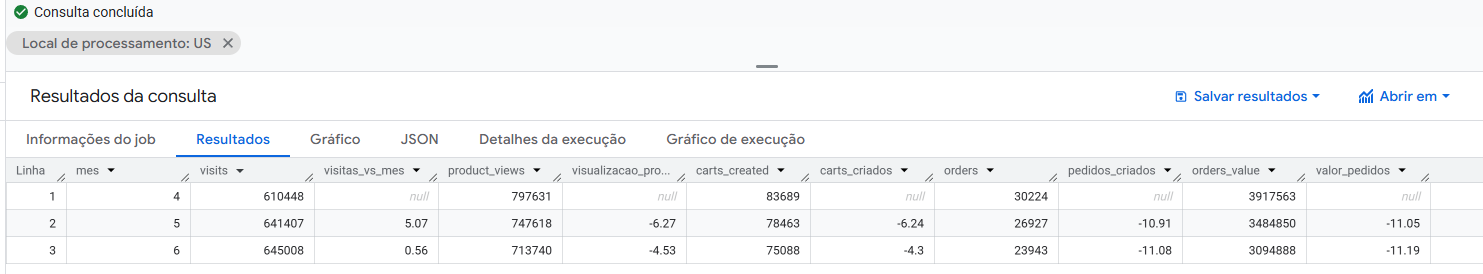

***Resposta: visualização caiu 10,8%, seguindo downgrade 10,5% de carrinhos criados e diminuição de 20.7% de pedidos criados, que diminui a receita em 22%. ***

Quais são as aparentes causas para a queda de venda?
Tente entender os principais gargalos no funil de vendas e levantar hipóteses do que pode ter causado cada comportamento

***Resposta: Conforme citado acima, os pedidos criados diminuiram e levaram receita, visualização, e carrinhos abandonados, utilizando a outra tabela disponível vamos entender os números gerais e o que aconteceu do mês 4 (comportamento normal) para o mês 6 (pior comportamento)***

In [ ]:
## Códigos aleatórios para entender um pouco mais os números e consultar o comportamento anterior

In [ ]:

select
EXTRACT(MONTH FROM sold_at) mes
,seller_id
,count(*) as cont_vendas
 from `bi-candidatos.recruitment_analytics.orders`
group by all
order by cont_vendas desc

select
EXTRACT(MONTH FROM sold_at) AS mes
,product_id
,count(*) as cont_vendas
 from `bi-candidatos.recruitment_analytics.orders`
group by all
order by cont_vendas desc

select * from `bi-candidatos.recruitment_analytics.orders` limit 10

select distinct shipped_at from `bi-candidatos.recruitment_analytics.orders`

In [ ]:
## Aqui a validação que julgo principal para entender o possível motivo da queda de indicadores

In [ ]:
select
extract(month from sold_at)  mes
,order_status
,count(order_status) contagem_pedidos
,case when sold_at = shipped_at then 1 else 0 end as validador
from `bi-candidatos.recruitment_analytics.orders`
group by all
order by mes asc

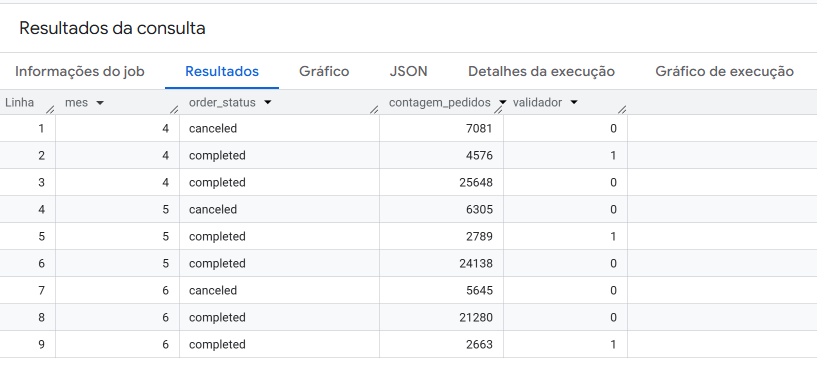

Tente entender os principais gargalos no funil de vendas e levantar hipóteses do que pode ter causado cada comportamento
**Resposta: Segundo os números no mês 4 temos entregas com a mesma data da compra e no mês seguinte temos uma queda de 39% e no mês 6 mais 4% de queda na pontualidade na entrega, a saída dos sellers que tiveram problema com a entrega pode ser o ofensor da diminuição de anúncio.**



Existem outras informações que seriam úteis para sua análise?
Por quê? Que respostas teríamos com essas informações adicionais?
**Resposta: Sim, precisaria na tabela orders o acesso a mais informações do seller, como região, segmento, tipo do produto, criar um depara para entender quais foram os produtos/áreas que diminuiram, entender se há sazonalidade ou algo do tipo, enriquecer essa tabela para criar uma tabela de funil mais asssertiva. **

Você consegue pensar em outras análises que ajudariam a alcançar o objetivo desse quarter?
Descreva as análises e os seus benefícios e impactos nas decisões do squad.
**Resposta: Sim, iniciaria uma análise voltada para a logística, ver se há um gargalo nos sellers, se houve alguma falha sazonal na região por cabeça de cep para cair tanto as entregas, tentar alavancar a volta desses sellers com acompanhamento via crm (jornada de save churn), entre outros **